<a href="https://colab.research.google.com/github/escaduto/BuildingExtraction/blob/test_colab/FireTrends_WesternUS_06182020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Trends in the Western US

## Setup Connection to Drive

In [1]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/COVID_FireTrends" 

import os
rootPath = "/content/drive/My Drive/COVID_FireTrends"
os.chdir(rootPath)

/content/drive/My Drive/COVID_FireTrends


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [50]:
!grep MemTotal /proc/meminfo

MemTotal:       26751700 kB


## Import Packages

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express"

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

In [4]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext):
              file_list.append(os.path.join(path,names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath 

## Interagency Perimeters

### Data Acquisition 

NearTime Perimeters (Current 7days): 

API: https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Public_Wildfire_Perimeters_View/FeatureServer/0/query?outFields=*&where=1%3D1

Archived Wildfire Perimeters 2019-2020:

API: https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Archived_Wildfire_Perimeters2/FeatureServer/0/query?outFields=*&where=1%3D1

Historic Perimeters (2000-2018): 
API: 
https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query?outFields=*&where=1%3D1


### Pre-processing 

In [ ]:
# access perimeter data in Drive
perimeter_path = 'Data/Interagency_FirePerimeters/'

fire_per = lstFiles(perimeter_path, '.shp')
fire_per

['Data/Interagency_FirePerimeters/2000_2018/US_HIST_FIRE_PERIMTRS_2000_2018_DD83.shp',
 'Data/Interagency_FirePerimeters/NIFC_2019/Public_NIFS_Archive_Perimeters.shp',
 'Data/Interagency_FirePerimeters/NIFC_2020/Public_NIFS_Perimeters.shp',
 'Data/Interagency_FirePerimeters/GeoMac_2019/US_HIST_FIRE_PERIM_2019_dd83.shp']

In [ ]:
df1 = gpd.read_file(fire_per[0])
df2 = gpd.read_file(fire_per[1])
df3 = gpd.read_file(fire_per[2])
df4 = gpd.read_file(fire_per[3])    

In [ ]:
column_names = ['IncidentNa', 'MapMethod', 'GISAcres', 'CreateDate', 'ComplexNam', 'geometry']
yr_range = range(2000, 2021)
mnth_range = range(3, 6)

def renameColumns(df, yr_range, mnth_range):
  '''
  make sure all columns name match 
  filter by column name, create datetime columns, filter by year range (2000 to 2020)
  '''
  df = df.rename(columns={'incidentna': 'IncidentNa', 
                          'mapmethod': 'MapMethod', 
                          'gisacres': 'GISAcres', 
                          'perimeterd': 'CreateDate', 
                          'complexnam': 'ComplexNam'})
  # filter by column
  df = df[column_names]
  # create column for year, month, day 
  df['CreateDate']= pd.to_datetime(df['CreateDate'], format='%Y-%m-%d')
  df['Year'] = pd.DatetimeIndex(df['CreateDate']).year
  df['Month'] = pd.DatetimeIndex(df['CreateDate']).month
  df['Day'] = pd.DatetimeIndex(df['CreateDate']).day
  # filter by year
  df = df[df.Year.isin(yr_range)]
  df = df[df.Month.isin(mnth_range)]
  return df

In [ ]:
df1 = renameColumns(df1, yr_range, mnth_range)
df2 = renameColumns(df2, yr_range, mnth_range)
df3 = renameColumns(df3, yr_range, mnth_range)
df4 = renameColumns(df4, yr_range, mnth_range)

df_frames = [df1, df2, df3, df4]
complete_df = pd.concat(df_frames)

In [ ]:
# filter out complex fires, only consider individual fires or else they will be double counted
complete_df = complete_df[(~complete_df.IncidentNa.str.contains('Complex', case=False, na=False, regex=True)
                          | (complete_df['ComplexNam'].isna() == True))]
complete_df = complete_df[(complete_df.geometry.type == 'Polygon') | (complete_df.geometry.type == 'MultiPolygon')]
complete_df = complete_df[complete_df['geometry'].isna() == False]

In [ ]:
complete_df.groupby('Year')['IncidentNa'].nunique()

In [ ]:
# add state column
# read state shp
states_list = ['Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Utah', 'Arizona', 
                    'Montana', 'Wyoming', 'Colorado', 'New Mexico']

def getWestBounds(states_list, state_path, layer):
  '''
  create boundary based on states list 
  spatial join with layer 
  '''
  states = gpd.read_file(state_path)
  western_states = states[(states.STATE_NAME.isin(states_list))]
  western_states = western_states.to_crs(layer.crs)
  western_states = western_states[['STATE_NAME', 'STATE_ABBR', 'geometry']]  
  # Spatial join state and fire perimeter layers
  if western_states.crs == layer.crs:
    west_fires = gpd.sjoin(layer, western_states, op="within")
    west_fires = west_fires.drop(columns='index_right')
  else: 
    print('Make sure crs match!')
  return west_fires

In [ ]:
import rtree

In [ ]:
# access perimeter data in Drive
state_path = 'Data/US_states/'
west_fires = getWestBounds(states_list, state_path, complete_df)

In [ ]:
len(west_fires)

3918

In [ ]:
# standardize string, capitalize names 
west_fires['IncidentNa'] = west_fires.IncidentNa.str.capitalize()
# drop na values for GIS acres
west_fires = west_fires.dropna(subset=['GISAcres'])

campFires = west_fires[west_fires['IncidentNa'] == 'Camp']

In [ ]:
campFires[5:7]

,IncidentNa,MapMethod,GISAcres,CreateDate,ComplexNam,geometry,Year,Month,Day,STATE_NAME,STATE_ABBR


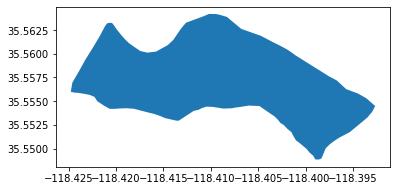

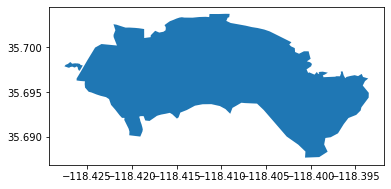

In [ ]:
# example of dupe entry for Camp fire on 2004-07-22 in CA due to diff map methods
campFires[5:6].plot()
campFires[6:7].plot()

In [ ]:
# grab only one fire per incident based on max acres; i.e. filter by PolygonDat, IncidentNa, STATE_NAME 
# Get rid of redundancies 
# !! UPDATE TO CREATEDATE WITHIN a WEEK !! 
west_fires_filt = west_fires.groupby(['IncidentNa','CreateDate','STATE_NAME']).apply(lambda x: x.loc[x.GISAcres.idxmax()])
west_fires_filt['Year'] = west_fires_filt['Year'].astype(str).str[:4]

In [ ]:
west_fires_filt.groupby('Year')['IncidentNa'].nunique()

Year
2000     93
2001    144
2002    153
2003    105
2004    140
2005    162
2006    241
2007    225
2008    289
2009    164
2010    144
2011    172
2012    246
2013    206
2014    105
2015    111
2016    175
2017    271
2018    268
2019     77
2020    167
Name: IncidentNa, dtype: int64

### Visualize Fire Area & Count

In [ ]:
fire_by_yr = west_fires_filt.groupby(['STATE_ABBR','Year']).agg({'IncidentNa': 'count', 'GISAcres': ['sum', 'mean', 'std']}).reset_index()
fire_by_yr.columns = ['STATE_ABBR', 'Year', 'Count', 'Total (Acres)', 'Mean (Acres)', 'Stdv (Acres']
fire_by_yr['Year'] = fire_by_yr['Year'].astype('str')
fire_by_yr

,STATE_ABBR,Year,Count,Total (Acres),Mean (Acres),Stdv (Acres
0,AZ,2000,3,401.283460,133.761153,69.668893
1,AZ,2001,5,3368.480915,673.696183,582.706147
2,AZ,2002,10,82597.972872,8259.797287,13997.176012
3,AZ,2003,9,44169.282638,4907.698071,4477.181244
4,AZ,2004,9,45419.362629,5046.595848,6992.404276
...,...,...,...,...,...,...
208,WY,2016,24,18246.729181,760.280383,2523.460384
209,WY,2017,8,1270.832039,158.854005,394.372046
210,WY,2018,25,2585.155261,103.406210,395.907691
211,WY,2019,1,535.807930,535.807930,NaN


In [ ]:
sample = fire_by_yr[['STATE_ABBR', 'Year', 'Count']]
table = pd.pivot_table(sample, values='Count', index=['STATE_ABBR'],
                    columns=['Year'])
table

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
STATE_ABBR,,,,,,,,,,,,,,,,,,,,,
AZ,3.0,5.0,10.0,9.0,9.0,28.0,30.0,11.0,23.0,24.0,13.0,19.0,36.0,25.0,32.0,17.0,51.0,58.0,30.0,67.0,32.0
CA,41.0,67.0,76.0,48.0,97.0,75.0,49.0,96.0,177.0,79.0,52.0,36.0,32.0,100.0,23.0,11.0,11.0,33.0,20.0,26.0,8.0
CO,3.0,3.0,26.0,NaN,8.0,2.0,19.0,14.0,8.0,4.0,10.0,22.0,19.0,18.0,7.0,13.0,14.0,21.0,26.0,5.0,4.0
ID,20.0,30.0,6.0,16.0,5.0,18.0,32.0,20.0,13.0,3.0,13.0,4.0,42.0,33.0,17.0,21.0,16.0,47.0,44.0,15.0,31.0
MT,NaN,2.0,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,3.0,NaN,23.0,1.0,1.0,6.0,4.0,34.0,3.0,NaN,9.0
NM,4.0,9.0,13.0,11.0,5.0,11.0,27.0,10.0,42.0,35.0,40.0,70.0,12.0,4.0,5.0,10.0,25.0,18.0,20.0,33.0,1.0
NV,7.0,17.0,2.0,9.0,10.0,8.0,55.0,31.0,17.0,6.0,3.0,6.0,19.0,4.0,2.0,10.0,7.0,30.0,54.0,1.0,68.0
OR,13.0,10.0,9.0,7.0,2.0,2.0,6.0,8.0,4.0,3.0,1.0,3.0,7.0,11.0,7.0,13.0,8.0,11.0,15.0,7.0,2.0
UT,2.0,4.0,10.0,5.0,3.0,17.0,15.0,30.0,5.0,2.0,7.0,12.0,44.0,8.0,4.0,4.0,10.0,14.0,11.0,3.0,15.0


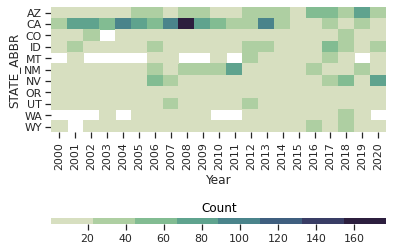

In [ ]:
import seaborn as sns
sns.set(style='ticks')
state_y = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

grid_kws = {"height_ratios": (1, 0.05), "hspace": 1.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(table, ax=ax, cmap= sns.cubehelix_palette(8, start=.5, rot=-.75),
                 cbar_ax=cbar_ax, yticklabels = state_y, 
                 cbar_kws={"orientation": "horizontal"})

plt.title('Count', color='black')
plt.savefig('Figures/Interagency_Count_HeatMap_0306.png', dpi = 400)

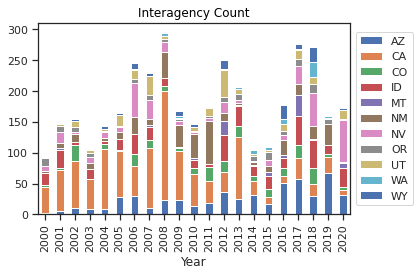

In [ ]:
table.set_index('STATE_ABBR').T.plot(kind='bar', stacked=True)
plt.title('Interagency Count', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig('Figures/Interagency_Count_stackedbar_0306.png', dpi = 400)

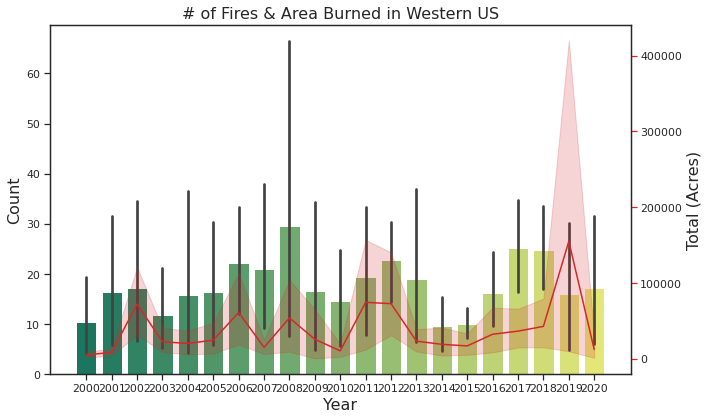

In [ ]:
import seaborn as sns
sns.set(style='ticks')
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('# of Fires & Area Burned in Western US', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Avg Temp', fontsize=16)
ax1 = sns.barplot(x='Year', y='Count', data = fire_by_yr, palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Avg Percipitation %', fontsize=16)
ax2 = sns.lineplot(x='Year', y='Total (Acres)', data = fire_by_yr, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
plt.tight_layout()
plt.savefig('Figures/Interagency_FireCount_AcresBurned_0306.png', dpi = 400)

## Active Fire Products


### Data Acquisition 

Archive Download: https://firms.modaps.eosdis.nasa.gov/download/


Near-RealTime (7 days) 

MODIS (C6): https://firms.modaps.eosdis.nasa.gov/data/active_fire/c6/shapes/zips/MODIS_C6_USA_contiguous_and_Hawaii_7d.zip

VIIRS (S-NPP): 
https://firms.modaps.eosdis.nasa.gov/data/active_fire/suomi-npp-viirs-c2/shapes/zips/SUOMI_VIIRS_C2_USA_contiguous_and_Hawaii_7d.zip

VIIRS (NOAA-20): Note: launched Nov 2017 
https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_USA_contiguous_and_Hawaii_7d.zip

### Pre-Processing

In [ ]:
# access perimeter data in Drive
AF_path = 'Data/Active_Fire_Products/'

af_pts = lstFiles(AF_path, '.shp')

In [ ]:
# read af files 
df1 = gpd.read_file(af_pts[0])
df2 = gpd.read_file(af_pts[1])
df3 = gpd.read_file(af_pts[2])
df4 = gpd.read_file(af_pts[3])
df5 = gpd.read_file(af_pts[4])

In [ ]:
frames = [df1, df2, df3, df4, df5]

def getFileInfo(dfFrames):
  '''
  From geodf in frames read from data folder with AF products, 
  create dictionary based on INSTRUMENT
  '''
  dic = {'MODIS': [], 'VIIRS': []}
  for i, df in enumerate(dfFrames): 
    minDate = min(df['ACQ_DATE'])
    maxDate = max(df['ACQ_DATE'])
    numEntries = len(df)
    print('filename: ', af_pts[i], '\nminDate: ', minDate, 
          '\nmaxDate: ',maxDate, '\nnumEntries: ',numEntries)
    x = 'df'+ str(i+1)
    if df['INSTRUMENT'][0] == 'MODIS': 
      dic['MODIS'].append(x)
    else: 
      dic['VIIRS'].append(x)
  return dic

In [ ]:
dic_frames = getFileInfo(frames)

In [ ]:
# combine based on sensor 
# MODIS AF (1km) 
MODIS_AF = pd.concat([eval(x) for x in dic_frames['MODIS']])

# VIIRS AF 
VIIRS_AF = pd.concat([eval(x) for x in dic_frames['VIIRS']])

In [ ]:
# clip to western US boundary 
state_path = 'Data/US_states/'
w_modis = getWestBounds(states_list, state_path, MODIS_AF) 
w_viirs = getWestBounds(states_list, state_path, VIIRS_AF) 

In [ ]:
def createDateFields(df, dt_field, dt_format):
  ''' from datetime field, creates 4 new columns: 
  Year, Month, Day, Julian Day
  '''
  df[dt_field]= pd.to_datetime(df[dt_field], format= dt_format)
  df['Year'] = pd.DatetimeIndex(df[dt_field]).year
  df['Month'] = pd.DatetimeIndex(df[dt_field]).month
  df['Day'] = pd.DatetimeIndex(df[dt_field]).day
  df['JD'] = df[dt_field].dt.strftime('%y%j').astype('int64')
  df['ACQ_DATE'] = df[dt_field].dt.strftime('%Y-%m-%d')
  df[dt_field] = df[dt_field].dt.strftime(dt_format)
  return df

In [ ]:
w_modis = createDateFields(w_modis, 'ACQ_DATE', '%Y-%m-%d')
w_viirs = createDateFields(w_viirs, 'ACQ_DATE', '%Y-%m-%d')

In [ ]:
outpath = "Data/Active_Fire_Products/Filtered"

w_viirs.to_file(os.path.join(outpath, 'VIIRS_AF_2017_2020.shp'))
w_modis.to_file(os.path.join(outpath, 'MODIS_1km_2017_2020.shp'))

In [ ]:
outpath = "Data/Active_Fire_Products/Filtered"
w_modis = gpd.read_file(os.path.join(outpath, 'MODIS_1km', 'MODIS_1km_2017_2020.shp'))

In [ ]:
# create shp for each day in yr 
rootpath = 'Data/MODIS_Resampling'

for yr in range(2017, 2020 + 1):
  #create folder by yr
  outpath = createFolder(rootpath, str(yr))
  df = w_modis[w_modis['Year'] == yr]
  for jd in df['JD'].unique().tolist():
    day_path = createFolder(outpath, str(jd)[-3:])
    daily_df = df[df['JD'] == jd]
    #daily_df['ACQ_DATE'] = daily_df['ACQ_DATE'].dt.strftime('%Y-%m-%d')
    daily_df.to_file(os.path.join(day_path, 'M6_' + str(yr) + "_" + str(jd)[-3:] + '.shp'))

In [ ]:
day_lst = w_modis['JD'].unique().tolist()

# def rasMod(MODISAF):
#   '''
#   resample MODIS AF points to 375m by rasterizing 
#   '''
#   for day in day_lst:
#     afLayer = MODIS_AF_EE.filter(ee.Filter.equals('JD', day))
#     ras = afLayer.reduceToImage(['JD'], ee.Reducer.first()).reproject(crs='epsg:4326', scale=1000)
#     region = MODIS_AF_EE.geometry().bounds()
#     ras_375 = ras.resample('bicubic').reproject(crs='epsg:4326', scale=375)
#     pt_375 = ras_375.reduceToVectors(**{'geometry': region, 'maxPixels':45135575, 'scale': 375,
#                                     'geometryType': 'centroid','labelProperty': 'JD'})

Resampling MODIS to 375m done using arcpy package and merged into 'Data/Active_Fire_Products/Filtered/MODIS_375m'

In [ ]:
! pip install geopandas

In [ ]:
import geopandas as gpd
import pandas as pd

In [ ]:
# Match VIIRS records
# add attributes (ACQ_DATE, LONGITUDE, LATITUDE, Month, Year) based on JD %y%j

mod_375 = gpd.read_file('Data/Active_Fire_Products/Filtered/MODIS_375m')

In [ ]:
# date columns 
mod_375_new = createDateFields(mod_375, 'grid_code', "%y%j")

# add lat/lon columns 
mod_375_new['LONGITUDE'] = mod_375_new['geometry'].x
mod_375_new['LATITUDE'] = mod_375_new['geometry'].y

# add state columns
state_path = 'Data/US_states/'
w_modis_375 = getWestBounds(states_list, state_path, mod_375_new) 

In [ ]:
w_modis_375['INSTRUMENT'] = 'MODIS'

In [ ]:
outpath = 'Data/Active_Fire_Products/Filtered/MODIS_375m'
# w_modis_375['grid_code'] = w_modis_375['grid_code'].dt.strftime('%Y-%m-%d')
w_modis_375.to_file(os.path.join(outpath, 'MODIS_375m_2017_2020.shp'))

### Add to GEE Assets

In [ ]:
# initialize and connect to GEE 
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee 
ee.Initialize()

In [54]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

geemap package not installed. Installing ...


In [ ]:
# Connect to google cloud 
! gcloud auth login

In [ ]:
# add filtered shp into cloud bucket for easier access 
!gsutil cp -r 'Data/Active_Fire_Products/Filtered/VIIRS' gs://activefires_bucket
!gsutil cp -r 'Data/Active_Fire_Products/Filtered/MODIS_1km' gs://activefires_bucket
!gsutil cp -r 'Data/Active_Fire_Products/Filtered/MODIS_375m' gs://activefires_bucket

In [ ]:
# export files hosted in cloud bucket as assets to GEE 
# needed to set up a bucket in google cloud: gs://esca_bucket
! earthengine upload table --asset_id=users/escaduto/Western_FireTrends/VIIRS_AF_2017_2020 gs://activefires_bucket/VIIRS/VIIRS_AF_2017_2020.shp
! earthengine upload table --asset_id=users/escaduto/Western_FireTrends/MODIS_375m_2017_2020 gs://activefires_bucket/MODIS_375m/MODIS_375m_2017_2020.shp

In [ ]:
# import feature collection asset 
VIIRS_AF_EE = ee.FeatureCollection('users/escaduto/Western_FireTrends/VIIRS_AF_2017_2020')
MODIS_AF_EE = ee.FeatureCollection('users/escaduto/Western_FireTrends/MODIS_375m_2017_2020')

## Define Fire Instance

Create groups of AF points based on criteria: distance & datetime to identify fire clusters.

### Perform Moving Search

In [ ]:
def addUniqueID(feature):
  '''
  add unique ID into properties based on JD, Time, Lat, Lon 
  ID's will be used for neighbor searches for identifying fire pnt clusters
  '''
  lat = ee.Number(feature.getNumber('LATITUDE')).multiply(100000).int().format('%s')
  lon = ee.Number(feature.getNumber('LONGITUDE')).multiply(100000).int().format('%s').replace('-', '')
  name = ee.Number(feature.getNumber('JD')).format('%s').cat(ee.String(feature.getString('ACQ_TIME'))).cat(lat).cat(lon)
  return feature.set('unique_id', name)

# Map the ID creation function over the FeatureCollection.
VIIRS_AF_EE = VIIRS_AF_EE.map(addUniqueID)

In [ ]:
# export AF layer with unique IDS 
task = ee.batch.Export.table.toDrive(**{'collection': VIIRS_AF_EE, 'description': 'VIIRS_Filt_2017_2020', 'folder':'Data', 'fileFormat': 'SHP'})
task.start()

In [ ]:
task.status()

In [ ]:
# Group by distance and datetime 
# for each VIIRS pnt, filter gt lt 7 days, distance within 100m 
# for selected pnts, do the same thing until None, return .distinct feature collection as 1 grouped fire pnts 

from datetime import datetime,timedelta

def dateRanges(afLayer, m):
  '''
  From iterating list, get date object and find +/- 7 day range 
  Returns new feature collection 
  '''
  date = m['properties']['ACQ_DATE']
  dt = datetime.strptime(date, '%Y-%m-%d')
  dt_jd = dt.strftime('%y%j')
  pre_dt = dt - timedelta(days=30)
  pre_jd = pre_dt.strftime('%y%j')
  post_dt = dt + timedelta(days=30)
  post_jd = post_dt.strftime('%y%j')
  filt_layer = afLayer.filter(ee.Filter.rangeContains('JD', int(pre_jd), int(post_jd)))
  return filt_layer

def filtBounds(filt_dt, m, dist_meters):
  '''
  Based on filtered date range layer, filter based on user defined distance 
  Returns new feature collection 
  '''
  geo_pt = ee.Geometry.Point((m['properties']['LONGITUDE'], m['properties']['LATITUDE']))
  buff = geo_pt.buffer(dist_meters)
  filt_layer = filt_dt.filterBounds(buff)
  return filt_layer

In [ ]:
def get_groups_recursion(af_list):
  '''
  Return List of List IDS for fire clusters based on af_list instances from predefined conditions of distance and datetime 
  For each neighbor recursively search until no neighbors that satisfy condition 
  '''
  visited_dict = {}
  track_groups = []
  for i, point in enumerate(af_list):
    print(i+1, ' out of ', len(af_list))
    grouped_points = get_group_helper(point, visited_dict)
    #print('visited ', len(visited_dict.keys()))
    if len(grouped_points) > 3:
      #print(grouped_points)
      track_groups.append(grouped_points)
  return track_groups

def get_group_helper(point, visited_dict):
  stack = [point]
  result = []
  while len(stack) > 0:
    curr_point = stack.pop()
    curr_point_id = curr_point['properties']['unique_id']
    if curr_point_id not in visited_dict:
      result.append(curr_point_id)
      visited_dict[curr_point_id] = True
    
      filt_dt = dateRanges(VIIRS_AF_EE, curr_point) # change to merged M6 + V1 file 
      filt_dist = filtBounds(filt_dt, curr_point, 3000)

      filt_list = filt_dist.toList(filt_dist.size())
      i_list= filt_list.getInfo() 

      for i, children_node in enumerate(i_list): 
        stack.append(children_node)
  return result

Save grouped IDS by state and year in csv for easier retrieval

In [ ]:
import csv
rootPath = 'Data/Tracker_CSV'

# filter by month (March, April, May, June)
# for state, by year create ID tracker csv 
states_list = [['New Mexico', 'NM'], ['Colorado', 'CO']]

# [['Montana', 'MT'], ['Wyoming', 'WY'], ['Idaho','ID'], 
#                ['Nevada', 'NV'], ['Oregon', 'OR'], ['Washington', 'WA'], ['Arizona', 'AZ'], 
#                ['California', 'CA'], ['Utah', 'UT'], ['New Mexico', 'NM'], ['Colorado', 'CO']]

years_range = range(2017, 2017 + 1)

for yr in years_range: 
  for st_full, st_abr in states_list: 
    print(str(yr), st_full)
    afLayer = VIIRS_AF_EE.filter(ee.Filter.rangeContains('Month', 3, 6)) 
    afLayer = afLayer.filter(ee.Filter.equals('Year', int(yr)))
    afLayer = afLayer.filter(ee.Filter.equals('STATE_ABBR', st_abr))
    lista = afLayer.toList(afLayer.size())
    af_list= lista.getInfo()
    groups = get_groups_recursion(af_list)
    outpath = createFolder(rootPath, st_full)
    with open(os.path.join(outpath, st_abr + "_" + str(yr) + '_fireID_tracker.csv'), 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(groups)


### Add Attribute 'Fire ID'

This is done with geopandas. Fire ID attribute is added based on dictionary created by the clustering method above. If unique_id matches find 'key' value that serves as a grouping ID to differentiate individual fire events. ** NOTE: Need to figure out how to do the same using ee .map over featurecollection.  

In [ ]:
# # function to return key for any value 
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
      #ee_val = ee.String(val)
      for v in value: 
        #ee_v = ee.String(v)
        #if ee_val.compareTo(ee_v).getInfo() == 0:
        if v == val: 
          return int(key) 
    return False 

In [ ]:
! pip install geopandas

In [ ]:
import geopandas as gpd 

# read in AF combined layer WITH unique_id field 
AF_Layer = gpd.read_file('Data/VIIRS_filt_2017_2020.shp')

####State & Year

In [ ]:
from csv import reader
# create new layers by State & Year 
csv_lst = lstFiles('Data/Tracker_CSV', '.csv')
outpath = 'Data/Fire_Instances'

for csv in csv_lst: 
  nm = csv.split('/')
  state_nm = nm[-2]
  file_name = nm[-1]
  nmm = file_name.split('_')
  yr = nmm[1]
  st_abbr = nmm[0]
  st_path = createFolder(outpath, state_nm)
  yr_path = createFolder(st_path, yr)
  file_path = os.path.join(yr_path, st_abbr + "_" + yr + "_AF.shp")
  if os.path.isfile(file_path) == False:
    print(st_abbr, yr)
    with open(csv, 'r') as read_obj:
      # pass the file object to reader() to get the reader object
      csv_reader = reader(read_obj)
      # Pass reader object to list() to get a list of lists
      list_of_rows = list(csv_reader)
      group = list_of_rows

    fire_dict = dict(zip(list(range(1, len(group) +1)), group))
    new_keys = []
    for id in AF_Layer['unique_id']:
      key = get_key(id, fire_dict)
      new_keys.append(key)
    
    # add new field and filter out non-grouped points 
    AF_Layer['fire_ID'] = new_keys
    new_fire_layer = AF_Layer[AF_Layer['fire_ID'] != False]
    new_fire_layer['fire_ID'] = new_fire_layer['fire_ID'].astype('int64')
    new_fire_layer.to_file(os.path.join(yr_path, st_abbr + "_" + yr + "_AF.shp"))

#### ALL

In [ ]:
#combine all files into one csv 
import csv 
from csv import reader

csv_lst = lstFiles('Data/Tracker_CSV', '.csv')
out_csv = "Data/Tracker_CSV/ALL_WesternUS/WesternUS_AF_2017_2020.csv"

if os.path.isfile(out_csv) == True:
  os.remove(out_csv)
else:
  with open(out_csv,'a') as fd:
    writer = csv.writer(fd)
    for fl in csv_lst:
      with open(fl, 'r') as read_obj:
        csv_reader = reader(read_obj)
        list_of_rows = list(csv_reader)
        writer.writerows(list_of_rows)

In [ ]:
with open(out_csv, 'r') as read_obj:
  # pass the file object to reader() to get the reader object
  csv_reader = reader(read_obj)
  # Pass reader object to list() to get a list of lists
  list_of_rows = list(csv_reader)
  group = list_of_rows

In [ ]:
# read in AF combined layer WITH unique_id field 
AF_Layer = gpd.read_file('Data/VIIRS_filt_2017_2020.shp')

In [ ]:
outpath = 'Data/Fire_Instances'

fire_dict = dict(zip(list(range(1, len(group) +1)), group))
new_keys = []
for id in AF_Layer['unique_id']:
  key = get_key(id, fire_dict)
  new_keys.append(key)

In [ ]:
# add new field and filter out non-grouped points 
AF_Layer['fire_ID'] = new_keys
new_fire_layer = AF_Layer[AF_Layer['fire_ID'] != False]
new_fire_layer['fire_ID'] = new_fire_layer['fire_ID'].astype('int64')
new_fire_layer.to_file(os.path.join(outpath, 'ALL_WesternUS', 'ALL_WesternUS_2017_2020.shp'))

In [ ]:
# import into bucket 
!gsutil cp -r 'Data/Fire_Instances/ALL_WesternUS' gs://activefires_bucket

In [ ]:
# import to assets 
! earthengine upload table --asset_id=users/escaduto/Western_FireTrends/VIIRS_Fire_ID_2017_2020 gs://activefires_bucket/ALL_WesternUS/ALL_WesternUS_2017_2020.shp

In [ ]:
# ee_dict = ee.Dictionary(fire_dict)
# dict_keys = ee_dict.keys()
# fire_dict = dict(zip(list(range(1, len(groups) +1)), groups))
# ee_dict = ee.Dictionary(fire_dict)

# def addAttribute(feature):
#   idName = ee.String(feature.getString('unique_id')) 
#   key = get_key(idName, ee_dict)
#   return key

# VIIRS_AF_EE.map(addAttribute)

# Map the ID creation function over the FeatureCollection.
#VIIRS_AF_EE_filt = VIIRS_AF_EE.map(addAttribute)
#VIIRS_AF_EE_filt = VIIRS_AF_EE_filt.filter(ee.Filter.neq('fire_key', None))

### Visualize Fire Groups

In [ ]:
VIIRS_FireGrp_EE = ee.FeatureCollection('users/escaduto/Western_FireTrends/VIIRS_Fire_ID_2017_2020')

In [ ]:
# search by points 
def getFireID(layer, coord):
  geo_pt = ee.Geometry.Point(coord)
  buff = geo_pt.buffer(1000)
  sample_fire = layer.filterBounds(buff)
  sample_info = sample_fire.first().getInfo()
  fire_id = sample_info['properties']['fire_ID']
  return fire_id

coord = (47.6617,  -110.7806)
search_id = getFireID(VIIRS_FireGrp_EE, coord)
search_id

3781

In [ ]:
sample = VIIRS_FireGrp_EE.filter(ee.Filter.equals('fire_ID', 1))
min_JD = sample.sort('JD', True).first().getInfo()['properties']['JD']
max_JD = sample.sort('JD', False).first().getInfo()['properties']['JD']
lat = sample.sort('JD', True).first().getInfo()['properties']['LATITUDE']
lon = sample.sort('JD', False).first().getInfo()['properties']['LONGITUDE']
min_JD, max_JD, lat, lon

(18059, 18070, 46.67552, -110.77136)

In [ ]:
# Visualize the resulting interpolated raster.
colors = ['00007F', '0000FF', '0074FF',
          '0DFFEA', '8CFF41', 'FFDD00',
          'FF3700', 'C30000', '790000']
vis = {'min':min_JD, 'max':max_JD, 'palette': colors}

In [ ]:
def visualizeByAttribute(fc, className): 
  '''
  visualize building polygon based on damage type 'class' (0,1) 
  '''   
  empty = ee.Image().byte()
  feature = empty.paint(**{
    'featureCollection': fc,
    'color': className,
    'width': 2
  })
  return feature

In [ ]:
sample_buff = sample.geometry().convexHull().buffer(3000)
clipped = sample_buff.intersection(MODIS_AF_EE)

In [ ]:
Map = emap.Map(center=[lat,lon], zoom=10)
Map.add_basemap('TERRAIN')
Map.addLayer(VII_MOD_AF, '', 'VII_MOD_AF')
Map.addLayer(VIIRS_FireGrp_EE, '', 'VIIRS_FireGrp_EE')
Map.addLayer(MOD_extracted, '', 'clipped')
Map.addLayer(visualizeByAttribute(sample, 'JD'), vis, 'sample')
Map.addLayerControl()
Map


## Extract & Merge VII + M6 

Either from Interagency perimeter, AF point bounds, and Landsat burn scar. For now, just use Viirs bounds w/ 3km buffer. 

In [ ]:
# for all fire_ID instance, filter get layer 
# get convex HULL and create buff
# when MODIS file contains in poly, filter by date range 

def mergeAF(ID, viirs_Grp, min_jd, max_jd, viGrp_geo):
  viGrp_buff = viGrp_geo.buffer(3000)
  MOD_filt_dt = MODIS_AF_EE.filter(ee.Filter.rangeContains('JD', min_jd  - 14, max_jd  + 14))
  MOD_extracted = MOD_filt_dt.filterBounds(viGrp_buff)
  MOD_extracted = MOD_extracted.map(fireID)
  VII_MOD_AF = viirs_Grp.merge(MOD_extracted)
  return VII_MOD_AF

ID = 1 
viirs_Grp = VIIRS_FireGrp_EE.filter(ee.Filter.equals('fire_ID', ID))
viirsPnts_list = viirs_Grp.toList(viirs_Grp.size())
v_list= viirsPnts_list.getInfo()
min_jd = min([x['properties']['JD'] for x in v_list])
max_jd = max([x['properties']['JD'] for x in v_list])
viGrp_geo = viirs_Grp.geometry().convexHull()

VII_MOD_AF = mergeAF(ID, viirs_Grp, min_jd, max_jd, viGrp_geo)

## Interpolation



### IDW

In [ ]:
# This is the name of the property to interpolate.
propertyToInterpolate = 'JD'

# Combine mean and SD reducers for efficiency.
combinedReducer = ee.Reducer.mean()\
                            .combine(reducer2=ee.Reducer.stdDev(),
                                     sharedInputs=True)

# Estimate global mean and standard deviation (SD) from the points.
stats = sample.reduceColumns(reducer=combinedReducer,
                                             selectors= [propertyToInterpolate])

# Do the interpolation, valid to 50 kilometers.
interpolated = sample.inverseDistance(range= 500,
                                          propertyName=propertyToInterpolate,
                                          mean=stats.get('mean'),
                                          stdDev=stats.get('stdDev'),
                                          gamma=0.05)

Map = emap.Map(center=[lat, lon], zoom=10)
Map.addLayer(interpolated, vis, 'inter')
Map.addLayer(sample, '', 'sample')
Map.addLayerControl()
Map

### Kriging

In [ ]:
# Interpolate 
interpolated = VII_MOD_AF.kriging(propertyName='JD',
                               shape='spherical',
                               range=500,
                               sill=1.0,
                               nugget=0.1,
                               maxDistance=500,
                               reducer='min')

Map = emap.Map(center=[lat,lon], zoom=12)
Map.addLayer(interpolated, vis, 'inter')
Map.addLayer(visualizeByAttribute(VII_MOD_AF, 'JD'), vis, 'sample')
Map.addLayerControl()
Map

## Convert to Vector 

In [ ]:
sample_geo = VII_MOD_AF.geometry().convexHull()
vectors = interpolated.toLong().reduceToVectors(
  geometryType= 'polygon',
  geometry = sample_geo,
  scale=30,
  eightConnected= True,
  labelProperty= 'JD', crs= 'EPSG:4326')

In [ ]:
def visualizeByAttribute(fc, className): 
  '''
  visualize building polygon based on damage type 'class' (0,1) 
  '''   
  empty = ee.Image().byte()
  feature = empty.paint(**{
    'featureCollection': fc,
    'color': className,
    'width': 2
  })
  return feature

In [ ]:
Map = emap.Map(center=[lat,lon], zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayer(interpolated, vis, 'inter')
Map.addLayer(visualizeByAttribute(vectors, 'JD'), vis, 'perimeter')
Map.addLayer(visualizeByAttribute(VII_MOD_AF, 'JD'), vis, 'sample_pnts')
Map.addLayerControl()
Map

In [ ]:
file_name = 'sample_perimeter'
task = ee.batch.Export.table.toDrive(**{'collection': vectors, 'description': file_name, 'folder':'Data', 'fileFormat': 'SHP'})
task.start()

## Perform All Steps & Export 

1. Extract/Merge AF 
2. Interpolate 
3. Convert to Perimeter 

In [ ]:
import csv 
from csv import reader

out_csv = 'Data/Tracker_CSV/ALL_WesternUS/WesternUS_AF_2017_2020.csv'

with open(out_csv, 'r') as read_obj:
  # pass the file object to reader() to get the reader object
  csv_reader = reader(read_obj)
  # Pass reader object to list() to get a list of lists
  list_of_rows = list(csv_reader)
  group = list_of_rows
  
fire_dict = dict(zip(list(range(1, len(group) +1)), group))

In [ ]:
# get min/max fire_IDS to loop through 
min_ID = min(list(fire_dict.keys()))
max_ID = max(list(fire_dict.keys()))
min_ID, max_ID

(1, 3867)

In [ ]:
from datetime import datetime
def computeArea(feature):
  area = feature.geometry().area(1)
  return feature.set('Area', area)

def computeDate(feature):
  jd = ee.Number(feature.getNumber('JD')).format('%s')
  jd_dt = ee.Date.parse('yyDDD', jd)
  date_str = jd_dt.format('Y-MM-dd')
  return feature.set('Date', date_str)

def fireID(feature):
  ID = ee.Number(fire_ID)
  return feature.set('fire_ID', ID)

In [ ]:
# name >> State_Year_minJD_maxJD_FireID.ext
outpath = 'FinalProducts'
rootPath = "/content/drive/My Drive/COVID_FireTrends"

for fire_ID in range(663, max_ID + 1):
  try:
    os.chdir(rootPath)
    # filter by fireID
    viirs_Grp = VIIRS_FireGrp_EE.filter(ee.Filter.equals('fire_ID', fire_ID))
    viirsPnts_list = viirs_Grp.toList(viirs_Grp.size())
    v_list= viirsPnts_list.getInfo()

    # get min/max JD
    min_jd = min([x['properties']['JD'] for x in v_list])
    max_jd = max([x['properties']['JD'] for x in v_list])

    # get state, year info 
    state_full = v_list[0]['properties']['STATE_NAME']
    state_abr = v_list[0]['properties']['STATE_ABBR']
    year = v_list[0]['properties']['Year']

    file_name = state_abr + '_' + str(year) + '_' + str(min_jd)[-3:] + str(max_jd)[-3:] + '_' + str(fire_ID) 
    
    viGrp_geo = viirs_Grp.geometry().convexHull()
    # [1] merge all AF 
    Combined_AF = mergeAF(fire_ID, viirs_Grp, min_jd, max_jd, viGrp_geo)

    # compute range , sill, nugget , maxDistance
    #area = Combined_AF.geometry().convexHull().area()

    # [2] interpolate 
    interpolated = Combined_AF.kriging(propertyName='JD',
                                shape='spherical',
                                range=500,
                                sill=1.0,
                                nugget=0.1,
                                maxDistance=500,
                                reducer='min')
    
    # [3] Convert to geometry
    vectors = interpolated.toLong().reduceToVectors(
                geometryType= 'polygon',
                geometry = viGrp_geo,
                scale=30,
                eightConnected= True,
                labelProperty= 'JD', crs= 'EPSG:4326')
    
    # Add Area, Date, Fire_ID
    vec = vectors.map(computeArea)
    vec = vec.map(computeDate)
    vec = vec.map(fireID)

    # [4] Save all layers: Combined AF (.shp), Interpolated (.tif), Perimeters (.shp) into folder 
    vec_path = os.path.join(outpath, 'Perimeters')
    st_path = createFolder(vec_path, state_full)
    yr_path = createFolder(st_path, str(year))
    id_path = createFolder(yr_path, str(fire_ID))
    os.chdir(yr_path)
    print(file_name)
    task = ee.batch.Export.table.toDrive(**{'collection': vec, 'description': str(file_name), 'folder':str(fire_ID), 'fileFormat': 'SHP'})
    task.start()
  except: 
    print('error: ', file_name)
    continue


## Summary Stats

### Compile

In [ ]:
# grab all individual fire perimeters
outpath = 'Perimers/FinalProducts'
daily_per = lstFiles(outpath, 'shp')
daily_per[:5]

In [ ]:
from pathlib import Path
import pandas as pd 
import geopandas as gpd

outpath = 'FinalProducts'

gdf = pd.concat([
    gpd.read_file(shp)
    for shp in daily_per
]).pipe(gpd.GeoDataFrame)

In [ ]:
# add states
state_path = 'Data/US_states/'
west_fires = getWestBounds(states_list, state_path, gdf)

In [ ]:
# add acres / hectares 
west_fires['Area_acres'] = west_fires['Area'] * 0.00024710538146717 
west_fires['Area_hectares'] = west_fires['Area'] * 0.0001

In [ ]:
west_fires['Date']= pd.to_datetime(west_fires['Date'], format= '%Y-%m-%d')
west_fires['Year'] = pd.DatetimeIndex(west_fires['Date']).year
west_fires['Month'] = pd.DatetimeIndex(west_fires['Date']).month
west_fires['JD'] = west_fires['Date'].dt.strftime('%j').astype('int64')

west_fires = west_fires[(west_fires['Month'] >= 3) & (west_fires['Month'] <= 6)]
west_fires = west_fires[(west_fires['Area_hectares'] >= 3)]
west_fires.head()

In [ ]:
# count number of fire_ID by state, yr by week 
west_fires['Week'] = west_fires['Date'].apply(lambda x: "%d" % (x.week)).astype('int64')

In [ ]:
# save csv, .shp
outpath = 'FinalProducts'
outFolder = createFolder(outpath, 'ALL_WesternUS')
west_fires['Date'] = west_fires['Date'].dt.strftime('%Y-%m-%d')
west_fires.to_file(os.path.join(outFolder, 'ALLFirePer_0306_2017_2020.shp')) 
west_fires.to_csv(os.path.join(outpath, 'ALLFirePer_0306_2017_2020.csv'))

### Mask Non-Wildland Fires 
i.e urban, agricultral area

In [55]:
NLCD = ee.ImageCollection('USGS/NLCD').select('landcover').clip()

In [ ]:
states_list = ['Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Utah', 'Arizona', 
                    'Montana', 'Wyoming', 'Colorado', 'New Mexico']

In [59]:
Map = emap.Map(center=[-95, 38], zoom=5)
Map.addLayer(NLCD, '', 'NLCD')
Map.addLayerControl()
Map

### Plots

In [ ]:
west_fires = gpd.read_file(os.path.join(outFolder, 'ALLFirePer_0306_2017_2020.shp'))
west_fires.head()

,Area,count,JD,fire_ID,Date,STATE_NAME,STATE_ABBR,Area_acres,Area_hecta,Year,Month,Week,geometry
0,102903.145410,167,67,1,2018-03-08,Montana,MT,25.427921,10.290315,2018,3,10,"POLYGON ((-110.76093 46.67377, -110.76039 46.6..."
1,61619.251879,100,68,1,2018-03-09,Montana,MT,15.226449,6.161925,2018,3,10,"POLYGON ((-110.76147 46.67323, -110.76120 46.6..."
2,649484.079600,1054,69,1,2018-03-10,Montana,MT,160.491011,64.948408,2018,3,10,"POLYGON ((-110.76416 46.67458, -110.76389 46.6..."
3,51141.587381,83,64,1,2018-03-05,Montana,MT,12.637361,5.114159,2018,3,10,"POLYGON ((-110.76578 46.67458, -110.76416 46.6..."
4,38818.130756,63,63,1,2018-03-04,Montana,MT,9.592169,3.881813,2018,3,9,"POLYGON ((-110.76713 46.67458, -110.76578 46.6..."


In [ ]:
import seaborn as sns

#### Number of Fires

In [ ]:

west_fires_count = west_fires.groupby(['Week','Year', 'STATE_NAME'])['fire_ID'].nunique().reset_index()
west_fires_count.columns = ['Week', 'Year', 'STATE_NAME', 'Count']
west_fires_area = west_fires.groupby(['Week', 'Year', 'STATE_NAME'])['Area_hecta'].agg('sum').reset_index()
merged_left = pd.merge(left=west_fires_count, right=west_fires_area, how='left', on=['Week', 'Year', 'STATE_NAME'])

In [ ]:
merged_left.to_csv(os.path.join(outpath, 'WeeklyGrouped_0306_2017_2020.csv'), index=None)
merged_left

,Week,Year,STATE_NAME,Count,Area_hecta
0,9,2017,California,13,434.950030
1,9,2020,Washington,6,686.266455
2,9,2020,Oregon,3,56.182295
3,9,2020,Colorado,5,42.267931
4,9,2020,California,54,4638.831977
...,...,...,...,...,...
613,26,2017,California,23,5171.198388
614,26,2017,Arizona,14,22485.454070
615,26,2019,Utah,4,1924.029578
616,26,2018,Colorado,10,10357.921492


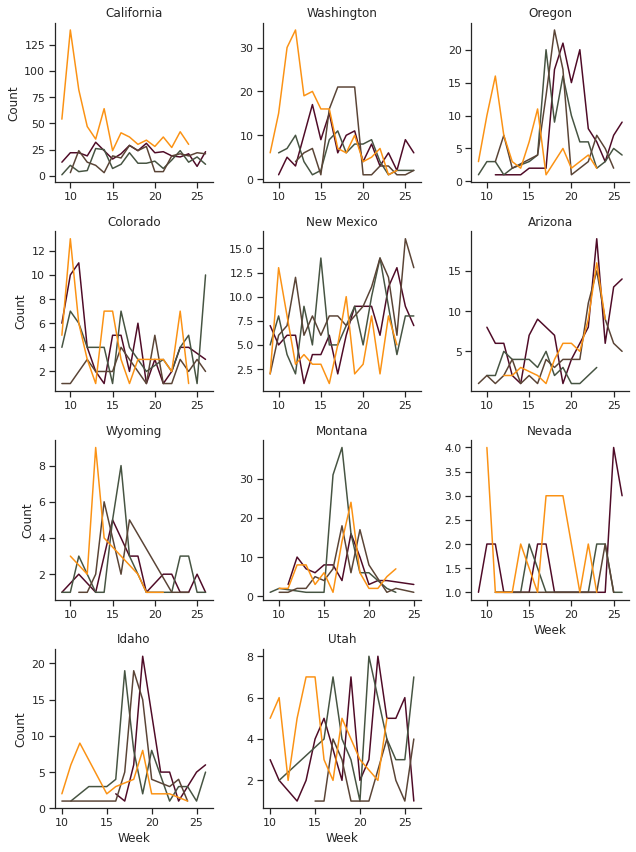

In [ ]:
sns.set(style='ticks')
# Define a palette to ensure that colors will be
# shared across the facets
yrs = [2017, 2018, 2019, 2020]
colors = ['#4f0b27', '#465442', '#5a4436', '#fb9214']
palette = dict(zip(yrs,colors))
kws=dict(sharex=False, sharey=False)

# Plot the lines on two facets
# g = sns.relplot(x="Week", y="Area_hectares", col_wrap=3,
#             hue="Year", col="STATE_NAME",
#             palette=palette, facet_kws=dict(sharex=False, sharey=False),
#             kind="line", legend="full", data=west_fires_area)

g = sns.FacetGrid(west_fires_grp, col="STATE_NAME", col_wrap=3, height=3, palette=palette, hue="Year",**kws)
g = (g.map(plt.plot, "Week", "Count")
    .set_titles("{col_name}")
    .set_ylabels('Count'))

plt.savefig('Figures/Fire_Count_Weekly.png', dpi = 200)

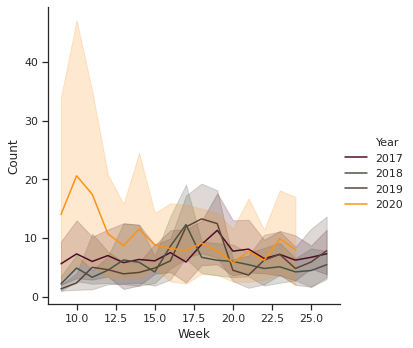

In [ ]:
# Plot the lines on two facets
sns.relplot(x="Week", y="Count",
            hue="Year", 
            palette=palette, facet_kws=dict(sharex=False, sharey=False),
            kind="line", legend="full", data=west_fires_grp)

plt.savefig('Figures/Fire_ALL_Count_Weekly.png', dpi = 400)

### AreaBurned

In [ ]:
west_fires['log_area'] = np.log10(west_fires.Area_hectares)

In [ ]:
west_fires_area = west_fires.groupby(['Week', 'Year', 'STATE_NAME'])['Area_hectares'].agg('sum').reset_index()
west_fires_area

,Week,Year,STATE_NAME,Area_hectares
0,9,2017,California,434.950030
1,9,2017,Colorado,965.642442
2,9,2017,Nevada,129.720543
3,9,2017,New Mexico,921.484194
4,9,2017,Wyoming,18.428681
...,...,...,...,...
613,26,2019,California,1133.849037
614,26,2019,Colorado,1400.973202
615,26,2019,New Mexico,5977.674576
616,26,2019,Utah,1924.029578


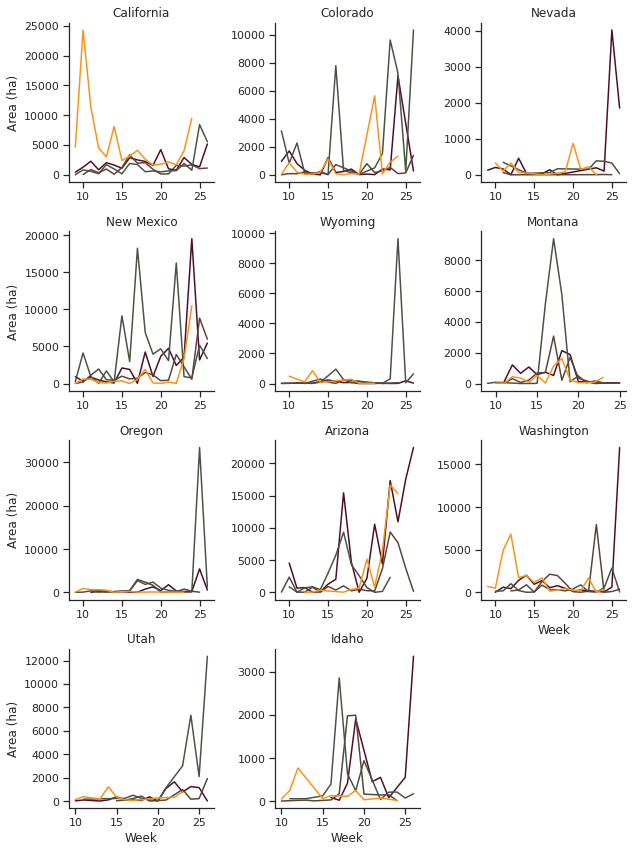

In [ ]:
sns.set(style='ticks')
# Define a palette to ensure that colors will be
# shared across the facets
yrs = [2017, 2018, 2019, 2020]
colors = ['#4f0b27', '#465442', '#5a4436', '#fb9214']
palette = dict(zip(yrs,colors))
kws=dict(sharex=False, sharey=False)

# Plot the lines on two facets
# g = sns.relplot(x="Week", y="Area_hectares", col_wrap=3,
#             hue="Year", col="STATE_NAME",
#             palette=palette, facet_kws=dict(sharex=False, sharey=False),
#             kind="line", legend="full", data=west_fires_area)

g = sns.FacetGrid(west_fires_area, col="STATE_NAME", col_wrap=3, height=3, palette=palette, hue="Year",**kws)
g = (g.map(plt.plot, "Week", "Area_hectares")
    .set_titles("{col_name}")
    .set_ylabels('Area (ha)'))

plt.savefig('Figures/Fire_AreaBurned_Weekly.png', dpi = 200)

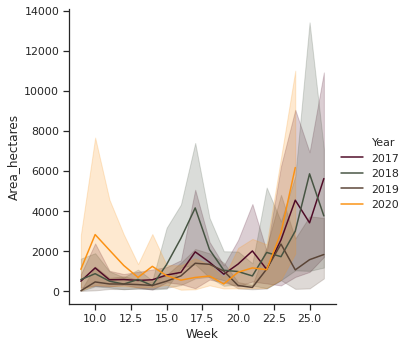

In [ ]:
# Plot the lines on two facets
sns.relplot(x="Week", y="Area_hectares", 
            hue="Year",
            palette=palette, facet_kws=dict(sharex=False, sharey=False),
            kind="line", legend="full", data=west_fires_area)

plt.savefig('Figures/Fire_ALL_AreaBurned_Weekly.png', dpi = 400)

## Git Setup

In [31]:
! echo "# WesternFireTrends" >> README.md

In [32]:
! git init
! git add README.md

Reinitialized existing Git repository in /content/drive/My Drive/COVID_FireTrends/.git/


In [60]:
! git config --global user.email "escaduto@ucdavis.edu"
! git config — global user.name escaduto

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

In [45]:
! git add 'FireTrends_WesternUS_06182020'

In [46]:
! git commit -m 'add firetrends notebook'

[master d96f376] add firetrends notebook
 1 file changed, 1 insertion(+), 1 deletion(-)


In [49]:
! git push

fatal: The current branch master has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin master



In [48]:
! git remote add origin https://github.com/escaduto/WesternFireTrends.git
! git push -u origin master

fatal: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address
